In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import os
from nltk.corpus import stopwords
import nltk
import string
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm.notebook import tqdm
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

In [2]:
dataset = load_dataset("conll2003")

In [3]:
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Benya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Benya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
lemmatizer = nltk.WordNetLemmatizer()

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = lemmatizer.lemmatize(text)

    return text

In [6]:
def preprocess_dataset(dataset):
    
    processed_dataset = []

    for row in dataset:
        
        row["tokens"] = list(map(preprocess_text, row["tokens"]))
        row["tokens"] = list(filter(lambda x: x not in string.punctuation, row["tokens"]))
        row.pop("id")
        row.pop("pos_tags")
        row.pop("chunk_tags")

        processed_dataset.append(row)

    return processed_dataset

In [7]:
train = preprocess_dataset(dataset["train"])
validation = preprocess_dataset(dataset["validation"])
test = preprocess_dataset(dataset["test"])

In [8]:
ner_tags = dataset["train"].features["ner_tags"].feature.names
#map to dictionary
ner_tags = {ner_tags[i]: i for i in range(len(ner_tags))}
print(ner_tags)

{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


In [9]:
MAX_LEN = 113

In [10]:
#getting the unique words in the dataset for vocab
vocab = {
    '<PAD>': 0,
    '<UNK>': 1
}
i = 2
for row in train:
    for word in row["tokens"]:
        if word not in vocab:
            vocab[word] = i
            i += 1

In [11]:
len(vocab)

19597

In [ ]:
emb = [
    [0.15,0.2],
    [0.1,0.25],
    [0.5,0.32],
]

seq = [0,0,1,2]

seq = [
    [0.15,0.2],
    [0.15,0.2],
    [0.1,0.25],
    [0.5,0.32],
]

In [12]:
#replace words with their index in the vocab
def word_to_idx(word):
    if word in vocab:
        return vocab[word]
    else:
        return vocab["<UNK>"]
    
def index(dataset):

    indexed_dataset = []

    for row in dataset:
        row["tokens"] = list(map(word_to_idx, row["tokens"]))       
        indexed_dataset.append(row)

    return indexed_dataset 

In [13]:
train = index(train)
validation = index(validation)
test = index(test)

In [14]:
NUM_CLASSES = len(dataset['train'].features['ner_tags'].feature.names)
print(NUM_CLASSES)

9


In [15]:
def pad_to_max_length(dataset):

    for row in dataset:
        if len(row["tokens"]) < MAX_LEN:
            row["tokens"] = row["tokens"] + [vocab['<PAD>']] * (MAX_LEN - len(row["tokens"]))
            row["ner_tags"] = row["ner_tags"] + [NUM_CLASSES] * (MAX_LEN - len(row["ner_tags"]))
        else:
            row["tokens"] = row["tokens"][:MAX_LEN]
            row["ner_tags"] = row["ner_tags"][:MAX_LEN]

    return dataset

In [66]:
#apply padding
train = pad_to_max_length(train)
validation = pad_to_max_length(validation)
test = pad_to_max_length(test)


In [71]:
def collate_fn(batch):
    tokens = torch.stack([torch.tensor(row["tokens"]) for row in batch])
    ner_tags = torch.stack([torch.tensor(row["ner_tags"]) for row in batch])

    return tokens, ner_tags

In [72]:
train_dataloader = DataLoader(train, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [19]:
#define gru model
class GRUModel(torch.nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(GRUModel, self).__init__()
        
        self.embedding = torch.nn.Embedding(vocab_size, 128)
        self.gru = torch.nn.GRU(128, 128, batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = self.fc(x)
        
        return x

In [20]:
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
model = GRUModel(len(vocab), NUM_CLASSES+1).to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.0005)
criterion = CrossEntropyLoss()
acc = MulticlassAccuracy(NUM_CLASSES+1).to(DEVICE)
f1 = MulticlassF1Score(NUM_CLASSES+1, average='macro').to(DEVICE)

history = {'train': {'loss': [], 'acc': [], 'f1': []},
           'val': {'loss': [], 'acc': [], 'f1': []}}

for epoch in range(EPOCHS):
    running_loss = 0.0
    running_acc = 0.0
    running_f1 = 0.0
    val_loss = 0.0
    val_acc = 0.0
    val_f1 = 0.0

    model.train()
    t = tqdm(train_dataloader)
    for i, (tokens, ner_tags) in enumerate(t):
        tokens, ner_tags = tokens.to(DEVICE), ner_tags.to(DEVICE)
        optimizer.zero_grad()
        output = model(tokens)

        # Calculate loss, accuracy, and F1 score
        loss = criterion(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        acc_score = acc(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        f1_score = f1(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc_score.item()
        running_f1 += f1_score.item()

    model.eval()
    with torch.no_grad():
        for tokens, ner_tags in validation_dataloader:
            tokens, ner_tags = tokens.to(DEVICE), ner_tags.to(DEVICE)
            output = model(tokens)

            loss = criterion(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
            acc_score = acc(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
            f1_score = f1(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))

            val_loss += loss.item()
            val_acc += acc_score.item()
            val_f1 += f1_score.item()

    # Calculate average loss, accuracy, and F1 score for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_acc = running_acc / len(train_dataloader)
    train_f1 = running_f1 / len(train_dataloader)

    val_loss = val_loss / len(validation_dataloader)
    val_acc = val_acc / len(validation_dataloader)
    val_f1 = val_f1 / len(validation_dataloader)

    # Store the metrics in the history dictionary
    history['train']['loss'].append(train_loss)
    history['train']['acc'].append(train_acc)
    history['train']['f1'].append(train_f1)
    history['val']['loss'].append(val_loss)
    history['val']['acc'].append(val_acc)
    history['val']['f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.1534, Train Acc: 0.1962, Train F1: 0.1894, Val Loss: 0.1239, Val Acc: 0.1985, Val F1: 0.1910


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 0.1015, Train Acc: 0.2130, Train F1: 0.2129, Val Loss: 0.1091, Val Acc: 0.2281, Val F1: 0.2373


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 0.0891, Train Acc: 0.2550, Train F1: 0.2730, Val Loss: 0.1006, Val Acc: 0.2636, Val F1: 0.2856


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 0.0789, Train Acc: 0.3130, Train F1: 0.3470, Val Loss: 0.0955, Val Acc: 0.3182, Val F1: 0.3556


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 0.0710, Train Acc: 0.3736, Train F1: 0.4194, Val Loss: 0.0961, Val Acc: 0.3779, Val F1: 0.4299


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 0.0638, Train Acc: 0.4345, Train F1: 0.4890, Val Loss: 0.0957, Val Acc: 0.3952, Val F1: 0.4522


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 0.0575, Train Acc: 0.4843, Train F1: 0.5413, Val Loss: 0.0910, Val Acc: 0.4381, Val F1: 0.4937


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 0.0521, Train Acc: 0.5337, Train F1: 0.5888, Val Loss: 0.0934, Val Acc: 0.4541, Val F1: 0.5115


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 0.0469, Train Acc: 0.5771, Train F1: 0.6293, Val Loss: 0.0978, Val Acc: 0.4894, Val F1: 0.5392


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.0419, Train Acc: 0.6227, Train F1: 0.6711, Val Loss: 0.1004, Val Acc: 0.4922, Val F1: 0.5397


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 0.0373, Train Acc: 0.6655, Train F1: 0.7122, Val Loss: 0.0999, Val Acc: 0.5113, Val F1: 0.5563


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 12/100, Train Loss: 0.0332, Train Acc: 0.6994, Train F1: 0.7411, Val Loss: 0.1034, Val Acc: 0.5118, Val F1: 0.5561


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 13/100, Train Loss: 0.0296, Train Acc: 0.7341, Train F1: 0.7713, Val Loss: 0.1088, Val Acc: 0.5153, Val F1: 0.5588


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 14/100, Train Loss: 0.0263, Train Acc: 0.7654, Train F1: 0.7980, Val Loss: 0.1124, Val Acc: 0.5133, Val F1: 0.5573


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 15/100, Train Loss: 0.0231, Train Acc: 0.7941, Train F1: 0.8231, Val Loss: 0.1189, Val Acc: 0.5174, Val F1: 0.5600


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 16/100, Train Loss: 0.0206, Train Acc: 0.8211, Train F1: 0.8458, Val Loss: 0.1218, Val Acc: 0.5298, Val F1: 0.5665


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 17/100, Train Loss: 0.0182, Train Acc: 0.8474, Train F1: 0.8686, Val Loss: 0.1269, Val Acc: 0.5201, Val F1: 0.5647


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 18/100, Train Loss: 0.0158, Train Acc: 0.8699, Train F1: 0.8882, Val Loss: 0.1307, Val Acc: 0.5080, Val F1: 0.5491


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 19/100, Train Loss: 0.0140, Train Acc: 0.8912, Train F1: 0.9083, Val Loss: 0.1389, Val Acc: 0.5322, Val F1: 0.5630


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.0122, Train Acc: 0.9058, Train F1: 0.9182, Val Loss: 0.1404, Val Acc: 0.5243, Val F1: 0.5586


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 21/100, Train Loss: 0.0106, Train Acc: 0.9220, Train F1: 0.9339, Val Loss: 0.1453, Val Acc: 0.5214, Val F1: 0.5606


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 22/100, Train Loss: 0.0091, Train Acc: 0.9401, Train F1: 0.9492, Val Loss: 0.1530, Val Acc: 0.5274, Val F1: 0.5617


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 23/100, Train Loss: 0.0082, Train Acc: 0.9497, Train F1: 0.9567, Val Loss: 0.1547, Val Acc: 0.5343, Val F1: 0.5614


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 24/100, Train Loss: 0.0070, Train Acc: 0.9587, Train F1: 0.9649, Val Loss: 0.1612, Val Acc: 0.5192, Val F1: 0.5505


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 25/100, Train Loss: 0.0061, Train Acc: 0.9652, Train F1: 0.9707, Val Loss: 0.1662, Val Acc: 0.5211, Val F1: 0.5516


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 26/100, Train Loss: 0.0056, Train Acc: 0.9705, Train F1: 0.9748, Val Loss: 0.1684, Val Acc: 0.5263, Val F1: 0.5572


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 27/100, Train Loss: 0.0054, Train Acc: 0.9696, Train F1: 0.9740, Val Loss: 0.1765, Val Acc: 0.5390, Val F1: 0.5695


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 28/100, Train Loss: 0.0046, Train Acc: 0.9766, Train F1: 0.9799, Val Loss: 0.1783, Val Acc: 0.5305, Val F1: 0.5595


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 29/100, Train Loss: 0.0040, Train Acc: 0.9807, Train F1: 0.9839, Val Loss: 0.1812, Val Acc: 0.5287, Val F1: 0.5591


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 30/100, Train Loss: 0.0037, Train Acc: 0.9824, Train F1: 0.9845, Val Loss: 0.1866, Val Acc: 0.5286, Val F1: 0.5573


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 31/100, Train Loss: 0.0035, Train Acc: 0.9845, Train F1: 0.9866, Val Loss: 0.1875, Val Acc: 0.5269, Val F1: 0.5524


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 32/100, Train Loss: 0.0034, Train Acc: 0.9841, Train F1: 0.9854, Val Loss: 0.1913, Val Acc: 0.5293, Val F1: 0.5578


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 33/100, Train Loss: 0.0031, Train Acc: 0.9875, Train F1: 0.9889, Val Loss: 0.1942, Val Acc: 0.5171, Val F1: 0.5477


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 34/100, Train Loss: 0.0029, Train Acc: 0.9884, Train F1: 0.9899, Val Loss: 0.1995, Val Acc: 0.5258, Val F1: 0.5508


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 35/100, Train Loss: 0.0028, Train Acc: 0.9878, Train F1: 0.9892, Val Loss: 0.1993, Val Acc: 0.5207, Val F1: 0.5490


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 36/100, Train Loss: 0.0027, Train Acc: 0.9889, Train F1: 0.9904, Val Loss: 0.1980, Val Acc: 0.5308, Val F1: 0.5530


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 37/100, Train Loss: 0.0025, Train Acc: 0.9904, Train F1: 0.9913, Val Loss: 0.2040, Val Acc: 0.5329, Val F1: 0.5581


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 38/100, Train Loss: 0.0024, Train Acc: 0.9903, Train F1: 0.9914, Val Loss: 0.2054, Val Acc: 0.5189, Val F1: 0.5458


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 39/100, Train Loss: 0.0024, Train Acc: 0.9904, Train F1: 0.9915, Val Loss: 0.2093, Val Acc: 0.5277, Val F1: 0.5539


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 40/100, Train Loss: 0.0022, Train Acc: 0.9915, Train F1: 0.9920, Val Loss: 0.2093, Val Acc: 0.5280, Val F1: 0.5556


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 41/100, Train Loss: 0.0019, Train Acc: 0.9933, Train F1: 0.9937, Val Loss: 0.2151, Val Acc: 0.5266, Val F1: 0.5561


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 42/100, Train Loss: 0.0022, Train Acc: 0.9917, Train F1: 0.9923, Val Loss: 0.2183, Val Acc: 0.5246, Val F1: 0.5520


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 43/100, Train Loss: 0.0021, Train Acc: 0.9933, Train F1: 0.9937, Val Loss: 0.2183, Val Acc: 0.5256, Val F1: 0.5526


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 44/100, Train Loss: 0.0018, Train Acc: 0.9938, Train F1: 0.9942, Val Loss: 0.2243, Val Acc: 0.5214, Val F1: 0.5516


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 45/100, Train Loss: 0.0017, Train Acc: 0.9943, Train F1: 0.9949, Val Loss: 0.2243, Val Acc: 0.5255, Val F1: 0.5519


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 46/100, Train Loss: 0.0017, Train Acc: 0.9936, Train F1: 0.9943, Val Loss: 0.2257, Val Acc: 0.5286, Val F1: 0.5533


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 47/100, Train Loss: 0.0017, Train Acc: 0.9943, Train F1: 0.9947, Val Loss: 0.2253, Val Acc: 0.5257, Val F1: 0.5520


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 48/100, Train Loss: 0.0016, Train Acc: 0.9945, Train F1: 0.9946, Val Loss: 0.2273, Val Acc: 0.5223, Val F1: 0.5492


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 49/100, Train Loss: 0.0017, Train Acc: 0.9929, Train F1: 0.9934, Val Loss: 0.2267, Val Acc: 0.5359, Val F1: 0.5595


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 50/100, Train Loss: 0.0018, Train Acc: 0.9924, Train F1: 0.9928, Val Loss: 0.2308, Val Acc: 0.5290, Val F1: 0.5566


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 51/100, Train Loss: 0.0017, Train Acc: 0.9941, Train F1: 0.9944, Val Loss: 0.2303, Val Acc: 0.5200, Val F1: 0.5499


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 52/100, Train Loss: 0.0017, Train Acc: 0.9937, Train F1: 0.9938, Val Loss: 0.2302, Val Acc: 0.5283, Val F1: 0.5559


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 53/100, Train Loss: 0.0014, Train Acc: 0.9950, Train F1: 0.9953, Val Loss: 0.2332, Val Acc: 0.5242, Val F1: 0.5474


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 54/100, Train Loss: 0.0012, Train Acc: 0.9955, Train F1: 0.9957, Val Loss: 0.2321, Val Acc: 0.5366, Val F1: 0.5590


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 55/100, Train Loss: 0.0013, Train Acc: 0.9958, Train F1: 0.9961, Val Loss: 0.2345, Val Acc: 0.5333, Val F1: 0.5593


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 56/100, Train Loss: 0.0013, Train Acc: 0.9949, Train F1: 0.9948, Val Loss: 0.2360, Val Acc: 0.5323, Val F1: 0.5534


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 57/100, Train Loss: 0.0014, Train Acc: 0.9952, Train F1: 0.9955, Val Loss: 0.2374, Val Acc: 0.5326, Val F1: 0.5547


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 58/100, Train Loss: 0.0018, Train Acc: 0.9938, Train F1: 0.9945, Val Loss: 0.2371, Val Acc: 0.5374, Val F1: 0.5578


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 59/100, Train Loss: 0.0013, Train Acc: 0.9956, Train F1: 0.9961, Val Loss: 0.2393, Val Acc: 0.5183, Val F1: 0.5476


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 60/100, Train Loss: 0.0012, Train Acc: 0.9957, Train F1: 0.9960, Val Loss: 0.2408, Val Acc: 0.5294, Val F1: 0.5560


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 61/100, Train Loss: 0.0013, Train Acc: 0.9961, Train F1: 0.9963, Val Loss: 0.2391, Val Acc: 0.5291, Val F1: 0.5506


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 62/100, Train Loss: 0.0013, Train Acc: 0.9964, Train F1: 0.9966, Val Loss: 0.2401, Val Acc: 0.5262, Val F1: 0.5474


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 63/100, Train Loss: 0.0013, Train Acc: 0.9953, Train F1: 0.9958, Val Loss: 0.2451, Val Acc: 0.5209, Val F1: 0.5518


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 64/100, Train Loss: 0.0011, Train Acc: 0.9964, Train F1: 0.9964, Val Loss: 0.2445, Val Acc: 0.5238, Val F1: 0.5520


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 65/100, Train Loss: 0.0011, Train Acc: 0.9961, Train F1: 0.9963, Val Loss: 0.2465, Val Acc: 0.5287, Val F1: 0.5547


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 66/100, Train Loss: 0.0009, Train Acc: 0.9966, Train F1: 0.9967, Val Loss: 0.2472, Val Acc: 0.5319, Val F1: 0.5565


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 67/100, Train Loss: 0.0012, Train Acc: 0.9964, Train F1: 0.9966, Val Loss: 0.2505, Val Acc: 0.5315, Val F1: 0.5596


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 68/100, Train Loss: 0.0013, Train Acc: 0.9957, Train F1: 0.9958, Val Loss: 0.2517, Val Acc: 0.5214, Val F1: 0.5513


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 69/100, Train Loss: 0.0013, Train Acc: 0.9957, Train F1: 0.9956, Val Loss: 0.2451, Val Acc: 0.5315, Val F1: 0.5522


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 70/100, Train Loss: 0.0012, Train Acc: 0.9956, Train F1: 0.9956, Val Loss: 0.2459, Val Acc: 0.5350, Val F1: 0.5584


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 71/100, Train Loss: 0.0009, Train Acc: 0.9969, Train F1: 0.9971, Val Loss: 0.2473, Val Acc: 0.5318, Val F1: 0.5569


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 72/100, Train Loss: 0.0008, Train Acc: 0.9974, Train F1: 0.9976, Val Loss: 0.2520, Val Acc: 0.5280, Val F1: 0.5549


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 73/100, Train Loss: 0.0008, Train Acc: 0.9972, Train F1: 0.9972, Val Loss: 0.2548, Val Acc: 0.5355, Val F1: 0.5670


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 74/100, Train Loss: 0.0010, Train Acc: 0.9973, Train F1: 0.9973, Val Loss: 0.2525, Val Acc: 0.5214, Val F1: 0.5487


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 75/100, Train Loss: 0.0012, Train Acc: 0.9958, Train F1: 0.9960, Val Loss: 0.2457, Val Acc: 0.5352, Val F1: 0.5602


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 76/100, Train Loss: 0.0011, Train Acc: 0.9963, Train F1: 0.9963, Val Loss: 0.2535, Val Acc: 0.5276, Val F1: 0.5564


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 77/100, Train Loss: 0.0011, Train Acc: 0.9969, Train F1: 0.9969, Val Loss: 0.2529, Val Acc: 0.5295, Val F1: 0.5579


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 78/100, Train Loss: 0.0011, Train Acc: 0.9963, Train F1: 0.9965, Val Loss: 0.2520, Val Acc: 0.5310, Val F1: 0.5524


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 79/100, Train Loss: 0.0009, Train Acc: 0.9974, Train F1: 0.9975, Val Loss: 0.2534, Val Acc: 0.5259, Val F1: 0.5580


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 80/100, Train Loss: 0.0009, Train Acc: 0.9973, Train F1: 0.9977, Val Loss: 0.2548, Val Acc: 0.5304, Val F1: 0.5576


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 81/100, Train Loss: 0.0009, Train Acc: 0.9974, Train F1: 0.9974, Val Loss: 0.2602, Val Acc: 0.5274, Val F1: 0.5587


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 82/100, Train Loss: 0.0009, Train Acc: 0.9967, Train F1: 0.9970, Val Loss: 0.2602, Val Acc: 0.5224, Val F1: 0.5524


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 83/100, Train Loss: 0.0009, Train Acc: 0.9970, Train F1: 0.9971, Val Loss: 0.2538, Val Acc: 0.5358, Val F1: 0.5633


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 84/100, Train Loss: 0.0008, Train Acc: 0.9976, Train F1: 0.9978, Val Loss: 0.2562, Val Acc: 0.5308, Val F1: 0.5598


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 85/100, Train Loss: 0.0007, Train Acc: 0.9980, Train F1: 0.9980, Val Loss: 0.2576, Val Acc: 0.5333, Val F1: 0.5561


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 86/100, Train Loss: 0.0007, Train Acc: 0.9980, Train F1: 0.9982, Val Loss: 0.2621, Val Acc: 0.5242, Val F1: 0.5555


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 87/100, Train Loss: 0.0008, Train Acc: 0.9976, Train F1: 0.9977, Val Loss: 0.2664, Val Acc: 0.5288, Val F1: 0.5574


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 88/100, Train Loss: 0.0010, Train Acc: 0.9966, Train F1: 0.9966, Val Loss: 0.2669, Val Acc: 0.5222, Val F1: 0.5511


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 89/100, Train Loss: 0.0013, Train Acc: 0.9953, Train F1: 0.9957, Val Loss: 0.2539, Val Acc: 0.5378, Val F1: 0.5562


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 90/100, Train Loss: 0.0011, Train Acc: 0.9959, Train F1: 0.9959, Val Loss: 0.2576, Val Acc: 0.5337, Val F1: 0.5602


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 91/100, Train Loss: 0.0010, Train Acc: 0.9963, Train F1: 0.9963, Val Loss: 0.2624, Val Acc: 0.5207, Val F1: 0.5504


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 92/100, Train Loss: 0.0008, Train Acc: 0.9972, Train F1: 0.9972, Val Loss: 0.2607, Val Acc: 0.5310, Val F1: 0.5549


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 93/100, Train Loss: 0.0008, Train Acc: 0.9977, Train F1: 0.9978, Val Loss: 0.2589, Val Acc: 0.5344, Val F1: 0.5607


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 94/100, Train Loss: 0.0008, Train Acc: 0.9973, Train F1: 0.9975, Val Loss: 0.2648, Val Acc: 0.5281, Val F1: 0.5554


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 95/100, Train Loss: 0.0007, Train Acc: 0.9984, Train F1: 0.9984, Val Loss: 0.2712, Val Acc: 0.5293, Val F1: 0.5577


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 96/100, Train Loss: 0.0006, Train Acc: 0.9984, Train F1: 0.9984, Val Loss: 0.2619, Val Acc: 0.5378, Val F1: 0.5640


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 97/100, Train Loss: 0.0008, Train Acc: 0.9972, Train F1: 0.9973, Val Loss: 0.2673, Val Acc: 0.5327, Val F1: 0.5608


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 98/100, Train Loss: 0.0009, Train Acc: 0.9974, Train F1: 0.9975, Val Loss: 0.2623, Val Acc: 0.5276, Val F1: 0.5531


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 99/100, Train Loss: 0.0009, Train Acc: 0.9975, Train F1: 0.9977, Val Loss: 0.2636, Val Acc: 0.5327, Val F1: 0.5535


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 100/100, Train Loss: 0.0009, Train Acc: 0.9972, Train F1: 0.9974, Val Loss: 0.2647, Val Acc: 0.5342, Val F1: 0.5574


In [22]:
#save model
torch.save(model.state_dict(), "gru_ner_model.pth")


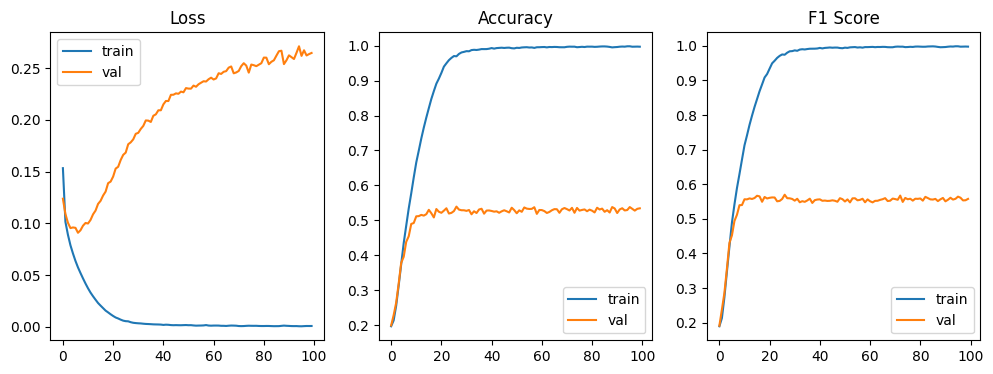

In [23]:
#plot the metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history['train']['loss'], label='train')
plt.plot(history['val']['loss'], label='val')
plt.title('Loss')
plt.legend()

#plot the accuracy
plt.subplot(1, 3, 2)
plt.plot(history['train']['acc'], label='train')
plt.plot(history['val']['acc'], label='val')
plt.title('Accuracy')
plt.legend()

#plot the f1 score
plt.subplot(1, 3, 3)
plt.plot(history['train']['f1'], label='train')
plt.plot(history['val']['f1'], label='val')
plt.title('F1 Score')
plt.legend()

plt.show()


In [45]:
glove_path = "glove.6B.100d.txt"
with open(glove_path, 'r', encoding='utf-8') as f:
    glove_embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype=np.float32)
        glove_embeddings[word] = vector


In [46]:
word_to_idx = {word: i for i, word in enumerate(vocab.keys())}

In [47]:
embedding_dim = 100  # Dimension of the GloVe embeddings
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_to_idx.items():
    if word in glove_embeddings:
        embedding_matrix[i] = glove_embeddings[word]

In [55]:
class ImprovedGRUModel(torch.nn.Module):
    def __init__(self, vocab_size, num_classes, embedding_matrix, dropout_rate=0.2):
        super(ImprovedGRUModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.gru = torch.nn.GRU(embedding_dim, 32, batch_first=True, bidirectional=True, dtype=torch.float32)
        self.fc = torch.nn.Linear(64, num_classes, dtype=torch.float32)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x

In [75]:
model = ImprovedGRUModel(len(vocab), NUM_CLASSES+1, embedding_matrix).to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.005)
criterion = CrossEntropyLoss()
acc = MulticlassAccuracy(NUM_CLASSES+1).to(DEVICE)
f1 = MulticlassF1Score(NUM_CLASSES+1, average='macro').to(DEVICE)

history = {'train': {'loss': [], 'acc': [], 'f1': []},
           'val': {'loss': [], 'acc': [], 'f1': []}}

for epoch in range(EPOCHS*2):
    running_loss = 0.0
    running_acc = 0.0
    running_f1 = 0.0
    val_loss = 0.0
    val_acc = 0.0
    val_f1 = 0.0

    model.train()
    t = tqdm(train_dataloader)
    for i, (tokens, ner_tags) in enumerate(t):
        tokens, ner_tags = tokens.to(DEVICE), ner_tags.to(DEVICE)
        optimizer.zero_grad()
        output = model(tokens)

        # Calculate loss, accuracy, and F1 score
        loss = criterion(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        acc_score = acc(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        f1_score = f1(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc_score.item()
        running_f1 += f1_score.item()

    model.eval()
    with torch.no_grad():
        for tokens, ner_tags in validation_dataloader:
            tokens, ner_tags = tokens.to(DEVICE), ner_tags.to(DEVICE)
            output = model(tokens)

            loss = criterion(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
            acc_score = acc(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
            f1_score = f1(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))

            val_loss += loss.item()
            val_acc += acc_score.item()
            val_f1 += f1_score.item()

    # Calculate average loss, accuracy, and F1 score for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_acc = running_acc / len(train_dataloader)
    train_f1 = running_f1 / len(train_dataloader)

    val_loss = val_loss / len(validation_dataloader)
    val_acc = val_acc / len(validation_dataloader)
    val_f1 = val_f1 / len(validation_dataloader)

    # Store the metrics in the history dictionary
    history['train']['loss'].append(train_loss)
    history['train']['acc'].append(train_acc)
    history['train']['f1'].append(train_f1)
    history['val']['loss'].append(val_loss)
    history['val']['acc'].append(val_acc)
    history['val']['f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.1270, Train Acc: 0.3052, Train F1: 0.3307, Val Loss: 0.0948, Val Acc: 0.3794, Val F1: 0.4206


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 0.0744, Train Acc: 0.4083, Train F1: 0.4532, Val Loss: 0.0908, Val Acc: 0.3816, Val F1: 0.4385


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 0.0695, Train Acc: 0.4405, Train F1: 0.4891, Val Loss: 0.0869, Val Acc: 0.4257, Val F1: 0.4824


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 0.0665, Train Acc: 0.4704, Train F1: 0.5196, Val Loss: 0.0897, Val Acc: 0.4282, Val F1: 0.4877


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 0.0645, Train Acc: 0.4873, Train F1: 0.5367, Val Loss: 0.0847, Val Acc: 0.4687, Val F1: 0.5198


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 0.0630, Train Acc: 0.4949, Train F1: 0.5434, Val Loss: 0.0824, Val Acc: 0.4841, Val F1: 0.5404


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 0.0616, Train Acc: 0.5122, Train F1: 0.5618, Val Loss: 0.0812, Val Acc: 0.4903, Val F1: 0.5404


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 0.0609, Train Acc: 0.5179, Train F1: 0.5658, Val Loss: 0.0819, Val Acc: 0.4790, Val F1: 0.5408


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 0.0599, Train Acc: 0.5266, Train F1: 0.5754, Val Loss: 0.0795, Val Acc: 0.4942, Val F1: 0.5478


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.0590, Train Acc: 0.5301, Train F1: 0.5789, Val Loss: 0.0798, Val Acc: 0.4728, Val F1: 0.5331


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 0.0582, Train Acc: 0.5365, Train F1: 0.5856, Val Loss: 0.0779, Val Acc: 0.5050, Val F1: 0.5634


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 12/100, Train Loss: 0.0576, Train Acc: 0.5425, Train F1: 0.5908, Val Loss: 0.0757, Val Acc: 0.5362, Val F1: 0.5803


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 13/100, Train Loss: 0.0574, Train Acc: 0.5486, Train F1: 0.5986, Val Loss: 0.0789, Val Acc: 0.5141, Val F1: 0.5697


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 14/100, Train Loss: 0.0566, Train Acc: 0.5537, Train F1: 0.6019, Val Loss: 0.0767, Val Acc: 0.5005, Val F1: 0.5608


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 15/100, Train Loss: 0.0563, Train Acc: 0.5577, Train F1: 0.6074, Val Loss: 0.0769, Val Acc: 0.5251, Val F1: 0.5843


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 16/100, Train Loss: 0.0560, Train Acc: 0.5613, Train F1: 0.6089, Val Loss: 0.0782, Val Acc: 0.5302, Val F1: 0.5785


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 17/100, Train Loss: 0.0557, Train Acc: 0.5595, Train F1: 0.6079, Val Loss: 0.0764, Val Acc: 0.5303, Val F1: 0.5793


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 18/100, Train Loss: 0.0553, Train Acc: 0.5621, Train F1: 0.6105, Val Loss: 0.0747, Val Acc: 0.5139, Val F1: 0.5754


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 19/100, Train Loss: 0.0549, Train Acc: 0.5706, Train F1: 0.6185, Val Loss: 0.0796, Val Acc: 0.5166, Val F1: 0.5722


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.0550, Train Acc: 0.5663, Train F1: 0.6146, Val Loss: 0.0758, Val Acc: 0.5103, Val F1: 0.5722


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 21/100, Train Loss: 0.0548, Train Acc: 0.5697, Train F1: 0.6181, Val Loss: 0.0762, Val Acc: 0.5178, Val F1: 0.5795


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 22/100, Train Loss: 0.0546, Train Acc: 0.5708, Train F1: 0.6184, Val Loss: 0.0777, Val Acc: 0.5098, Val F1: 0.5715


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 23/100, Train Loss: 0.0546, Train Acc: 0.5727, Train F1: 0.6198, Val Loss: 0.0735, Val Acc: 0.5303, Val F1: 0.5847


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 24/100, Train Loss: 0.0541, Train Acc: 0.5712, Train F1: 0.6181, Val Loss: 0.0754, Val Acc: 0.5254, Val F1: 0.5793


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 25/100, Train Loss: 0.0543, Train Acc: 0.5733, Train F1: 0.6209, Val Loss: 0.0755, Val Acc: 0.5336, Val F1: 0.5875


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 26/100, Train Loss: 0.0537, Train Acc: 0.5800, Train F1: 0.6276, Val Loss: 0.0766, Val Acc: 0.5329, Val F1: 0.5870


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 27/100, Train Loss: 0.0537, Train Acc: 0.5741, Train F1: 0.6225, Val Loss: 0.0755, Val Acc: 0.5126, Val F1: 0.5757


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 28/100, Train Loss: 0.0536, Train Acc: 0.5841, Train F1: 0.6308, Val Loss: 0.0723, Val Acc: 0.5215, Val F1: 0.5789


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 29/100, Train Loss: 0.0534, Train Acc: 0.5831, Train F1: 0.6313, Val Loss: 0.0752, Val Acc: 0.5254, Val F1: 0.5817


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 30/100, Train Loss: 0.0533, Train Acc: 0.5788, Train F1: 0.6266, Val Loss: 0.0769, Val Acc: 0.5150, Val F1: 0.5752


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 31/100, Train Loss: 0.0530, Train Acc: 0.5852, Train F1: 0.6333, Val Loss: 0.0770, Val Acc: 0.5302, Val F1: 0.5861


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 32/100, Train Loss: 0.0531, Train Acc: 0.5807, Train F1: 0.6281, Val Loss: 0.0746, Val Acc: 0.5260, Val F1: 0.5912


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 33/100, Train Loss: 0.0538, Train Acc: 0.5822, Train F1: 0.6283, Val Loss: 0.0752, Val Acc: 0.5164, Val F1: 0.5762


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 34/100, Train Loss: 0.0532, Train Acc: 0.5852, Train F1: 0.6323, Val Loss: 0.0754, Val Acc: 0.5227, Val F1: 0.5885


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 35/100, Train Loss: 0.0530, Train Acc: 0.5852, Train F1: 0.6335, Val Loss: 0.0742, Val Acc: 0.5298, Val F1: 0.5884


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 36/100, Train Loss: 0.0529, Train Acc: 0.5855, Train F1: 0.6330, Val Loss: 0.0746, Val Acc: 0.5282, Val F1: 0.5875


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 37/100, Train Loss: 0.0530, Train Acc: 0.5900, Train F1: 0.6367, Val Loss: 0.0748, Val Acc: 0.5481, Val F1: 0.5939


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 38/100, Train Loss: 0.0529, Train Acc: 0.5867, Train F1: 0.6341, Val Loss: 0.0764, Val Acc: 0.5306, Val F1: 0.5893


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 39/100, Train Loss: 0.0529, Train Acc: 0.5860, Train F1: 0.6333, Val Loss: 0.0743, Val Acc: 0.5530, Val F1: 0.6041


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 40/100, Train Loss: 0.0526, Train Acc: 0.5910, Train F1: 0.6377, Val Loss: 0.0739, Val Acc: 0.5287, Val F1: 0.5869


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 41/100, Train Loss: 0.0527, Train Acc: 0.5862, Train F1: 0.6341, Val Loss: 0.0747, Val Acc: 0.5390, Val F1: 0.5907


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 42/100, Train Loss: 0.0527, Train Acc: 0.5887, Train F1: 0.6348, Val Loss: 0.0757, Val Acc: 0.5301, Val F1: 0.5893


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 43/100, Train Loss: 0.0525, Train Acc: 0.5871, Train F1: 0.6359, Val Loss: 0.0739, Val Acc: 0.5468, Val F1: 0.5976


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 44/100, Train Loss: 0.0523, Train Acc: 0.5939, Train F1: 0.6419, Val Loss: 0.0719, Val Acc: 0.5198, Val F1: 0.5837


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 45/100, Train Loss: 0.0523, Train Acc: 0.5880, Train F1: 0.6344, Val Loss: 0.0732, Val Acc: 0.5358, Val F1: 0.5990


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 46/100, Train Loss: 0.0521, Train Acc: 0.5963, Train F1: 0.6402, Val Loss: 0.0738, Val Acc: 0.5138, Val F1: 0.5790


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 47/100, Train Loss: 0.0523, Train Acc: 0.5916, Train F1: 0.6372, Val Loss: 0.0727, Val Acc: 0.5338, Val F1: 0.5960


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 48/100, Train Loss: 0.0519, Train Acc: 0.5973, Train F1: 0.6436, Val Loss: 0.0730, Val Acc: 0.5568, Val F1: 0.6104


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 49/100, Train Loss: 0.0525, Train Acc: 0.5912, Train F1: 0.6373, Val Loss: 0.0743, Val Acc: 0.5486, Val F1: 0.6010


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 50/100, Train Loss: 0.0523, Train Acc: 0.5914, Train F1: 0.6367, Val Loss: 0.0744, Val Acc: 0.5396, Val F1: 0.5960


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 51/100, Train Loss: 0.0519, Train Acc: 0.5889, Train F1: 0.6356, Val Loss: 0.0730, Val Acc: 0.5382, Val F1: 0.5890


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 52/100, Train Loss: 0.0522, Train Acc: 0.5894, Train F1: 0.6361, Val Loss: 0.0731, Val Acc: 0.5465, Val F1: 0.6023


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 53/100, Train Loss: 0.0521, Train Acc: 0.5917, Train F1: 0.6377, Val Loss: 0.0754, Val Acc: 0.5280, Val F1: 0.5892


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 54/100, Train Loss: 0.0524, Train Acc: 0.5928, Train F1: 0.6386, Val Loss: 0.0740, Val Acc: 0.5488, Val F1: 0.5961


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 55/100, Train Loss: 0.0522, Train Acc: 0.5856, Train F1: 0.6334, Val Loss: 0.0721, Val Acc: 0.5604, Val F1: 0.6086


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 56/100, Train Loss: 0.0519, Train Acc: 0.5933, Train F1: 0.6395, Val Loss: 0.0727, Val Acc: 0.5502, Val F1: 0.6017


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 57/100, Train Loss: 0.0520, Train Acc: 0.5935, Train F1: 0.6416, Val Loss: 0.0720, Val Acc: 0.5533, Val F1: 0.6041


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 58/100, Train Loss: 0.0518, Train Acc: 0.5932, Train F1: 0.6399, Val Loss: 0.0721, Val Acc: 0.5292, Val F1: 0.5864


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 59/100, Train Loss: 0.0518, Train Acc: 0.5934, Train F1: 0.6389, Val Loss: 0.0744, Val Acc: 0.5121, Val F1: 0.5775


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 60/100, Train Loss: 0.0520, Train Acc: 0.5909, Train F1: 0.6376, Val Loss: 0.0725, Val Acc: 0.5510, Val F1: 0.5987


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 61/100, Train Loss: 0.0517, Train Acc: 0.6000, Train F1: 0.6476, Val Loss: 0.0747, Val Acc: 0.5462, Val F1: 0.5959


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 62/100, Train Loss: 0.0521, Train Acc: 0.5947, Train F1: 0.6422, Val Loss: 0.0727, Val Acc: 0.5409, Val F1: 0.5944


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 63/100, Train Loss: 0.0519, Train Acc: 0.5985, Train F1: 0.6459, Val Loss: 0.0736, Val Acc: 0.5227, Val F1: 0.5878


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 64/100, Train Loss: 0.0517, Train Acc: 0.5945, Train F1: 0.6405, Val Loss: 0.0723, Val Acc: 0.5375, Val F1: 0.5930


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 65/100, Train Loss: 0.0518, Train Acc: 0.5938, Train F1: 0.6412, Val Loss: 0.0714, Val Acc: 0.5494, Val F1: 0.5985


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 66/100, Train Loss: 0.0516, Train Acc: 0.5954, Train F1: 0.6438, Val Loss: 0.0718, Val Acc: 0.5380, Val F1: 0.5976


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 67/100, Train Loss: 0.0518, Train Acc: 0.5930, Train F1: 0.6400, Val Loss: 0.0739, Val Acc: 0.5371, Val F1: 0.5962


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 68/100, Train Loss: 0.0517, Train Acc: 0.5913, Train F1: 0.6388, Val Loss: 0.0732, Val Acc: 0.5433, Val F1: 0.6010


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 69/100, Train Loss: 0.0515, Train Acc: 0.5961, Train F1: 0.6438, Val Loss: 0.0728, Val Acc: 0.5403, Val F1: 0.5957


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 70/100, Train Loss: 0.0517, Train Acc: 0.5937, Train F1: 0.6426, Val Loss: 0.0725, Val Acc: 0.5455, Val F1: 0.5974


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 71/100, Train Loss: 0.0517, Train Acc: 0.5933, Train F1: 0.6382, Val Loss: 0.0723, Val Acc: 0.5509, Val F1: 0.6063


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 72/100, Train Loss: 0.0518, Train Acc: 0.5943, Train F1: 0.6420, Val Loss: 0.0716, Val Acc: 0.5411, Val F1: 0.5965


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 73/100, Train Loss: 0.0519, Train Acc: 0.5893, Train F1: 0.6369, Val Loss: 0.0731, Val Acc: 0.5389, Val F1: 0.6001


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 74/100, Train Loss: 0.0515, Train Acc: 0.5966, Train F1: 0.6421, Val Loss: 0.0732, Val Acc: 0.5377, Val F1: 0.5959


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 75/100, Train Loss: 0.0517, Train Acc: 0.5987, Train F1: 0.6457, Val Loss: 0.0721, Val Acc: 0.5391, Val F1: 0.5904


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 76/100, Train Loss: 0.0516, Train Acc: 0.5914, Train F1: 0.6389, Val Loss: 0.0747, Val Acc: 0.5602, Val F1: 0.6125


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 77/100, Train Loss: 0.0515, Train Acc: 0.5951, Train F1: 0.6411, Val Loss: 0.0743, Val Acc: 0.5316, Val F1: 0.5885


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 78/100, Train Loss: 0.0515, Train Acc: 0.5938, Train F1: 0.6415, Val Loss: 0.0728, Val Acc: 0.5472, Val F1: 0.6037


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 79/100, Train Loss: 0.0514, Train Acc: 0.5974, Train F1: 0.6450, Val Loss: 0.0733, Val Acc: 0.5249, Val F1: 0.5860


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 80/100, Train Loss: 0.0515, Train Acc: 0.5964, Train F1: 0.6428, Val Loss: 0.0747, Val Acc: 0.5520, Val F1: 0.6018


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 81/100, Train Loss: 0.0513, Train Acc: 0.5952, Train F1: 0.6424, Val Loss: 0.0727, Val Acc: 0.5355, Val F1: 0.5894


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 82/100, Train Loss: 0.0516, Train Acc: 0.5943, Train F1: 0.6409, Val Loss: 0.0736, Val Acc: 0.5591, Val F1: 0.6012


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 83/100, Train Loss: 0.0516, Train Acc: 0.5911, Train F1: 0.6379, Val Loss: 0.0751, Val Acc: 0.5463, Val F1: 0.6018


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 84/100, Train Loss: 0.0514, Train Acc: 0.5969, Train F1: 0.6435, Val Loss: 0.0731, Val Acc: 0.5453, Val F1: 0.5955


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 85/100, Train Loss: 0.0517, Train Acc: 0.5977, Train F1: 0.6438, Val Loss: 0.0728, Val Acc: 0.5378, Val F1: 0.5948


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 86/100, Train Loss: 0.0514, Train Acc: 0.5936, Train F1: 0.6416, Val Loss: 0.0746, Val Acc: 0.5564, Val F1: 0.6073


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 87/100, Train Loss: 0.0513, Train Acc: 0.5965, Train F1: 0.6430, Val Loss: 0.0728, Val Acc: 0.5444, Val F1: 0.6035


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 88/100, Train Loss: 0.0516, Train Acc: 0.5938, Train F1: 0.6407, Val Loss: 0.0733, Val Acc: 0.5389, Val F1: 0.5932


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 89/100, Train Loss: 0.0517, Train Acc: 0.5970, Train F1: 0.6423, Val Loss: 0.0736, Val Acc: 0.5229, Val F1: 0.5860


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 90/100, Train Loss: 0.0513, Train Acc: 0.5943, Train F1: 0.6415, Val Loss: 0.0745, Val Acc: 0.5296, Val F1: 0.5805


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 91/100, Train Loss: 0.0514, Train Acc: 0.5947, Train F1: 0.6426, Val Loss: 0.0728, Val Acc: 0.5427, Val F1: 0.5986


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 92/100, Train Loss: 0.0517, Train Acc: 0.5923, Train F1: 0.6396, Val Loss: 0.0736, Val Acc: 0.5423, Val F1: 0.5978


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 93/100, Train Loss: 0.0512, Train Acc: 0.5936, Train F1: 0.6409, Val Loss: 0.0727, Val Acc: 0.5553, Val F1: 0.6062


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 94/100, Train Loss: 0.0627, Train Acc: 0.5466, Train F1: 0.5933, Val Loss: 0.0959, Val Acc: 0.4316, Val F1: 0.4881


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 95/100, Train Loss: 0.0757, Train Acc: 0.4665, Train F1: 0.5156, Val Loss: 0.0945, Val Acc: 0.4338, Val F1: 0.4904


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 96/100, Train Loss: 0.0748, Train Acc: 0.4712, Train F1: 0.5213, Val Loss: 0.0948, Val Acc: 0.4310, Val F1: 0.4908


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 97/100, Train Loss: 0.0741, Train Acc: 0.4744, Train F1: 0.5259, Val Loss: 0.0929, Val Acc: 0.4425, Val F1: 0.4968


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 98/100, Train Loss: 0.0736, Train Acc: 0.4788, Train F1: 0.5298, Val Loss: 0.0936, Val Acc: 0.4438, Val F1: 0.5005


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 99/100, Train Loss: 0.0734, Train Acc: 0.4795, Train F1: 0.5294, Val Loss: 0.0946, Val Acc: 0.4381, Val F1: 0.4978


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 100/100, Train Loss: 0.0736, Train Acc: 0.4780, Train F1: 0.5280, Val Loss: 0.0928, Val Acc: 0.4542, Val F1: 0.5060


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 101/100, Train Loss: 0.0735, Train Acc: 0.4778, Train F1: 0.5287, Val Loss: 0.0932, Val Acc: 0.4486, Val F1: 0.4998


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 102/100, Train Loss: 0.0734, Train Acc: 0.4832, Train F1: 0.5335, Val Loss: 0.0923, Val Acc: 0.4435, Val F1: 0.5034


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 103/100, Train Loss: 0.0733, Train Acc: 0.4778, Train F1: 0.5289, Val Loss: 0.0948, Val Acc: 0.4396, Val F1: 0.5002


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 104/100, Train Loss: 0.0729, Train Acc: 0.4817, Train F1: 0.5325, Val Loss: 0.0933, Val Acc: 0.4353, Val F1: 0.4914


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 105/100, Train Loss: 0.0725, Train Acc: 0.4870, Train F1: 0.5377, Val Loss: 0.0926, Val Acc: 0.4421, Val F1: 0.5019


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 106/100, Train Loss: 0.0724, Train Acc: 0.4868, Train F1: 0.5367, Val Loss: 0.0924, Val Acc: 0.4430, Val F1: 0.5006


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 107/100, Train Loss: 0.0724, Train Acc: 0.4870, Train F1: 0.5377, Val Loss: 0.0917, Val Acc: 0.4535, Val F1: 0.5055


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 108/100, Train Loss: 0.0721, Train Acc: 0.4852, Train F1: 0.5360, Val Loss: 0.0924, Val Acc: 0.4560, Val F1: 0.5134


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 109/100, Train Loss: 0.0720, Train Acc: 0.4847, Train F1: 0.5351, Val Loss: 0.0930, Val Acc: 0.4599, Val F1: 0.5137


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 110/100, Train Loss: 0.0718, Train Acc: 0.4859, Train F1: 0.5350, Val Loss: 0.0919, Val Acc: 0.4411, Val F1: 0.4991


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 111/100, Train Loss: 0.0710, Train Acc: 0.4867, Train F1: 0.5373, Val Loss: 0.0912, Val Acc: 0.4540, Val F1: 0.5092


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 112/100, Train Loss: 0.0709, Train Acc: 0.4925, Train F1: 0.5446, Val Loss: 0.0909, Val Acc: 0.4565, Val F1: 0.5104


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 113/100, Train Loss: 0.0700, Train Acc: 0.4977, Train F1: 0.5492, Val Loss: 0.0908, Val Acc: 0.4577, Val F1: 0.5143


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 114/100, Train Loss: 0.0695, Train Acc: 0.4959, Train F1: 0.5459, Val Loss: 0.0899, Val Acc: 0.4558, Val F1: 0.5126


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 115/100, Train Loss: 0.0691, Train Acc: 0.4979, Train F1: 0.5487, Val Loss: 0.0887, Val Acc: 0.4607, Val F1: 0.5173


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 116/100, Train Loss: 0.0684, Train Acc: 0.5002, Train F1: 0.5495, Val Loss: 0.0905, Val Acc: 0.4472, Val F1: 0.5076


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 117/100, Train Loss: 0.0677, Train Acc: 0.5067, Train F1: 0.5569, Val Loss: 0.0874, Val Acc: 0.4694, Val F1: 0.5243


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 118/100, Train Loss: 0.0670, Train Acc: 0.5057, Train F1: 0.5567, Val Loss: 0.0866, Val Acc: 0.4705, Val F1: 0.5264


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 119/100, Train Loss: 0.0661, Train Acc: 0.5087, Train F1: 0.5593, Val Loss: 0.0861, Val Acc: 0.4605, Val F1: 0.5155


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 120/100, Train Loss: 0.0657, Train Acc: 0.5081, Train F1: 0.5577, Val Loss: 0.0844, Val Acc: 0.4715, Val F1: 0.5261


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 121/100, Train Loss: 0.0648, Train Acc: 0.5160, Train F1: 0.5662, Val Loss: 0.0848, Val Acc: 0.4669, Val F1: 0.5279


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 122/100, Train Loss: 0.0639, Train Acc: 0.5216, Train F1: 0.5728, Val Loss: 0.0834, Val Acc: 0.4975, Val F1: 0.5503


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 123/100, Train Loss: 0.0631, Train Acc: 0.5220, Train F1: 0.5731, Val Loss: 0.0840, Val Acc: 0.4714, Val F1: 0.5284


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 124/100, Train Loss: 0.0625, Train Acc: 0.5233, Train F1: 0.5738, Val Loss: 0.0829, Val Acc: 0.4842, Val F1: 0.5381


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 125/100, Train Loss: 0.0611, Train Acc: 0.5364, Train F1: 0.5845, Val Loss: 0.0813, Val Acc: 0.4930, Val F1: 0.5462


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 126/100, Train Loss: 0.0604, Train Acc: 0.5368, Train F1: 0.5858, Val Loss: 0.0818, Val Acc: 0.4868, Val F1: 0.5460


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 127/100, Train Loss: 0.0599, Train Acc: 0.5385, Train F1: 0.5878, Val Loss: 0.0793, Val Acc: 0.5145, Val F1: 0.5716


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 128/100, Train Loss: 0.0586, Train Acc: 0.5467, Train F1: 0.5962, Val Loss: 0.0789, Val Acc: 0.4980, Val F1: 0.5580


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 129/100, Train Loss: 0.0578, Train Acc: 0.5518, Train F1: 0.6001, Val Loss: 0.0788, Val Acc: 0.5186, Val F1: 0.5725


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 130/100, Train Loss: 0.0569, Train Acc: 0.5560, Train F1: 0.6048, Val Loss: 0.0791, Val Acc: 0.5201, Val F1: 0.5751


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 131/100, Train Loss: 0.0561, Train Acc: 0.5645, Train F1: 0.6120, Val Loss: 0.0796, Val Acc: 0.5184, Val F1: 0.5772


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 132/100, Train Loss: 0.0552, Train Acc: 0.5705, Train F1: 0.6182, Val Loss: 0.0760, Val Acc: 0.5270, Val F1: 0.5833


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 133/100, Train Loss: 0.0543, Train Acc: 0.5746, Train F1: 0.6218, Val Loss: 0.0754, Val Acc: 0.5254, Val F1: 0.5837


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 134/100, Train Loss: 0.0540, Train Acc: 0.5760, Train F1: 0.6241, Val Loss: 0.0770, Val Acc: 0.5105, Val F1: 0.5763


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 135/100, Train Loss: 0.0532, Train Acc: 0.5817, Train F1: 0.6295, Val Loss: 0.0769, Val Acc: 0.5130, Val F1: 0.5753


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 136/100, Train Loss: 0.0528, Train Acc: 0.5858, Train F1: 0.6334, Val Loss: 0.0760, Val Acc: 0.5504, Val F1: 0.5984


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 137/100, Train Loss: 0.0526, Train Acc: 0.5882, Train F1: 0.6355, Val Loss: 0.0750, Val Acc: 0.5410, Val F1: 0.5922


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 138/100, Train Loss: 0.0522, Train Acc: 0.5886, Train F1: 0.6363, Val Loss: 0.0752, Val Acc: 0.5353, Val F1: 0.5927


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 139/100, Train Loss: 0.0518, Train Acc: 0.5865, Train F1: 0.6345, Val Loss: 0.0752, Val Acc: 0.5369, Val F1: 0.5916


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 140/100, Train Loss: 0.0519, Train Acc: 0.5894, Train F1: 0.6363, Val Loss: 0.0736, Val Acc: 0.5405, Val F1: 0.5944


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 141/100, Train Loss: 0.0516, Train Acc: 0.5926, Train F1: 0.6407, Val Loss: 0.0753, Val Acc: 0.5399, Val F1: 0.5961


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 142/100, Train Loss: 0.0514, Train Acc: 0.5957, Train F1: 0.6412, Val Loss: 0.0743, Val Acc: 0.5448, Val F1: 0.5959


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 143/100, Train Loss: 0.0516, Train Acc: 0.5972, Train F1: 0.6458, Val Loss: 0.0729, Val Acc: 0.5432, Val F1: 0.6024


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 144/100, Train Loss: 0.0518, Train Acc: 0.5919, Train F1: 0.6395, Val Loss: 0.0741, Val Acc: 0.5277, Val F1: 0.5906


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 145/100, Train Loss: 0.0515, Train Acc: 0.5947, Train F1: 0.6431, Val Loss: 0.0748, Val Acc: 0.5492, Val F1: 0.5990


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 146/100, Train Loss: 0.0516, Train Acc: 0.5945, Train F1: 0.6426, Val Loss: 0.0742, Val Acc: 0.5530, Val F1: 0.6025


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 147/100, Train Loss: 0.0518, Train Acc: 0.5913, Train F1: 0.6378, Val Loss: 0.0738, Val Acc: 0.5320, Val F1: 0.5907


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 148/100, Train Loss: 0.0518, Train Acc: 0.5938, Train F1: 0.6412, Val Loss: 0.0732, Val Acc: 0.5377, Val F1: 0.5917


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 149/100, Train Loss: 0.0517, Train Acc: 0.5898, Train F1: 0.6366, Val Loss: 0.0720, Val Acc: 0.5389, Val F1: 0.5960


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 150/100, Train Loss: 0.0519, Train Acc: 0.5937, Train F1: 0.6407, Val Loss: 0.0740, Val Acc: 0.5381, Val F1: 0.5956


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 151/100, Train Loss: 0.0513, Train Acc: 0.5924, Train F1: 0.6408, Val Loss: 0.0744, Val Acc: 0.5212, Val F1: 0.5828


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 152/100, Train Loss: 0.0514, Train Acc: 0.5972, Train F1: 0.6442, Val Loss: 0.0733, Val Acc: 0.5200, Val F1: 0.5819


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 153/100, Train Loss: 0.0521, Train Acc: 0.5886, Train F1: 0.6357, Val Loss: 0.0731, Val Acc: 0.5504, Val F1: 0.6023


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 154/100, Train Loss: 0.0516, Train Acc: 0.5933, Train F1: 0.6392, Val Loss: 0.0727, Val Acc: 0.5357, Val F1: 0.5920


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 155/100, Train Loss: 0.0525, Train Acc: 0.5909, Train F1: 0.6376, Val Loss: 0.0725, Val Acc: 0.5354, Val F1: 0.5896


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 156/100, Train Loss: 0.0521, Train Acc: 0.5895, Train F1: 0.6371, Val Loss: 0.0746, Val Acc: 0.5410, Val F1: 0.5969


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 157/100, Train Loss: 0.0516, Train Acc: 0.5930, Train F1: 0.6411, Val Loss: 0.0741, Val Acc: 0.5295, Val F1: 0.5918


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 158/100, Train Loss: 0.0518, Train Acc: 0.5959, Train F1: 0.6432, Val Loss: 0.0712, Val Acc: 0.5286, Val F1: 0.5884


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 159/100, Train Loss: 0.0517, Train Acc: 0.5930, Train F1: 0.6408, Val Loss: 0.0736, Val Acc: 0.5517, Val F1: 0.6005


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 160/100, Train Loss: 0.0518, Train Acc: 0.5877, Train F1: 0.6340, Val Loss: 0.0737, Val Acc: 0.5322, Val F1: 0.5881


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 161/100, Train Loss: 0.0516, Train Acc: 0.5927, Train F1: 0.6404, Val Loss: 0.0759, Val Acc: 0.5259, Val F1: 0.5917


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 162/100, Train Loss: 0.0517, Train Acc: 0.5929, Train F1: 0.6395, Val Loss: 0.0730, Val Acc: 0.5607, Val F1: 0.6093


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 163/100, Train Loss: 0.0519, Train Acc: 0.5941, Train F1: 0.6418, Val Loss: 0.0742, Val Acc: 0.5245, Val F1: 0.5845


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 164/100, Train Loss: 0.0515, Train Acc: 0.5932, Train F1: 0.6420, Val Loss: 0.0735, Val Acc: 0.5340, Val F1: 0.5889


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 165/100, Train Loss: 0.0516, Train Acc: 0.5947, Train F1: 0.6416, Val Loss: 0.0726, Val Acc: 0.5294, Val F1: 0.5851


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 166/100, Train Loss: 0.0516, Train Acc: 0.5939, Train F1: 0.6392, Val Loss: 0.0742, Val Acc: 0.5325, Val F1: 0.5907


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 167/100, Train Loss: 0.0514, Train Acc: 0.5971, Train F1: 0.6429, Val Loss: 0.0728, Val Acc: 0.5390, Val F1: 0.5975


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 168/100, Train Loss: 0.0516, Train Acc: 0.5933, Train F1: 0.6412, Val Loss: 0.0730, Val Acc: 0.5550, Val F1: 0.6063


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 169/100, Train Loss: 0.0516, Train Acc: 0.5991, Train F1: 0.6467, Val Loss: 0.0725, Val Acc: 0.5512, Val F1: 0.6055


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 170/100, Train Loss: 0.0514, Train Acc: 0.5980, Train F1: 0.6443, Val Loss: 0.0737, Val Acc: 0.5496, Val F1: 0.6024


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 171/100, Train Loss: 0.0522, Train Acc: 0.5894, Train F1: 0.6375, Val Loss: 0.0720, Val Acc: 0.5512, Val F1: 0.6049


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 172/100, Train Loss: 0.0515, Train Acc: 0.5934, Train F1: 0.6404, Val Loss: 0.0725, Val Acc: 0.5408, Val F1: 0.5927


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 173/100, Train Loss: 0.0514, Train Acc: 0.5933, Train F1: 0.6400, Val Loss: 0.0710, Val Acc: 0.5513, Val F1: 0.6064


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 174/100, Train Loss: 0.0515, Train Acc: 0.5964, Train F1: 0.6445, Val Loss: 0.0727, Val Acc: 0.5370, Val F1: 0.5981


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 175/100, Train Loss: 0.0516, Train Acc: 0.5922, Train F1: 0.6394, Val Loss: 0.0736, Val Acc: 0.5327, Val F1: 0.5868


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 176/100, Train Loss: 0.0515, Train Acc: 0.5966, Train F1: 0.6438, Val Loss: 0.0711, Val Acc: 0.5348, Val F1: 0.5901


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 177/100, Train Loss: 0.0515, Train Acc: 0.5949, Train F1: 0.6418, Val Loss: 0.0724, Val Acc: 0.5380, Val F1: 0.5990


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 178/100, Train Loss: 0.0512, Train Acc: 0.5988, Train F1: 0.6465, Val Loss: 0.0733, Val Acc: 0.5319, Val F1: 0.5925


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 179/100, Train Loss: 0.0516, Train Acc: 0.5983, Train F1: 0.6459, Val Loss: 0.0747, Val Acc: 0.5372, Val F1: 0.5925


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 180/100, Train Loss: 0.0514, Train Acc: 0.5982, Train F1: 0.6450, Val Loss: 0.0739, Val Acc: 0.5467, Val F1: 0.5992


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 181/100, Train Loss: 0.0576, Train Acc: 0.5812, Train F1: 0.6273, Val Loss: 0.0745, Val Acc: 0.5318, Val F1: 0.5875


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 182/100, Train Loss: 0.0536, Train Acc: 0.5853, Train F1: 0.6327, Val Loss: 0.0735, Val Acc: 0.5197, Val F1: 0.5831


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 183/100, Train Loss: 0.0527, Train Acc: 0.5907, Train F1: 0.6371, Val Loss: 0.0730, Val Acc: 0.5371, Val F1: 0.5951


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 184/100, Train Loss: 0.0522, Train Acc: 0.5893, Train F1: 0.6372, Val Loss: 0.0740, Val Acc: 0.5342, Val F1: 0.5897


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 185/100, Train Loss: 0.0522, Train Acc: 0.5901, Train F1: 0.6366, Val Loss: 0.0741, Val Acc: 0.5344, Val F1: 0.5979


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 186/100, Train Loss: 0.0523, Train Acc: 0.5868, Train F1: 0.6351, Val Loss: 0.0757, Val Acc: 0.5393, Val F1: 0.5957


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 187/100, Train Loss: 0.0526, Train Acc: 0.5834, Train F1: 0.6309, Val Loss: 0.0734, Val Acc: 0.5267, Val F1: 0.5869


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 188/100, Train Loss: 0.0522, Train Acc: 0.5923, Train F1: 0.6395, Val Loss: 0.0738, Val Acc: 0.5408, Val F1: 0.5956


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 189/100, Train Loss: 0.0522, Train Acc: 0.5877, Train F1: 0.6349, Val Loss: 0.0733, Val Acc: 0.5271, Val F1: 0.5827


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 190/100, Train Loss: 0.0523, Train Acc: 0.5811, Train F1: 0.6275, Val Loss: 0.0740, Val Acc: 0.5413, Val F1: 0.5975


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 191/100, Train Loss: 0.0520, Train Acc: 0.5891, Train F1: 0.6357, Val Loss: 0.0727, Val Acc: 0.5378, Val F1: 0.5951


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 192/100, Train Loss: 0.0523, Train Acc: 0.5857, Train F1: 0.6331, Val Loss: 0.0745, Val Acc: 0.5402, Val F1: 0.5957


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 193/100, Train Loss: 0.0524, Train Acc: 0.5879, Train F1: 0.6346, Val Loss: 0.0755, Val Acc: 0.5236, Val F1: 0.5835


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 194/100, Train Loss: 0.0526, Train Acc: 0.5890, Train F1: 0.6359, Val Loss: 0.0769, Val Acc: 0.5132, Val F1: 0.5702


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 195/100, Train Loss: 0.0537, Train Acc: 0.5799, Train F1: 0.6278, Val Loss: 0.0754, Val Acc: 0.5309, Val F1: 0.5878


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 196/100, Train Loss: 0.0522, Train Acc: 0.5844, Train F1: 0.6321, Val Loss: 0.0738, Val Acc: 0.5507, Val F1: 0.6067


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 197/100, Train Loss: 0.0520, Train Acc: 0.5908, Train F1: 0.6364, Val Loss: 0.0740, Val Acc: 0.5348, Val F1: 0.5935


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 198/100, Train Loss: 0.0523, Train Acc: 0.5858, Train F1: 0.6325, Val Loss: 0.0745, Val Acc: 0.5314, Val F1: 0.5909


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 199/100, Train Loss: 0.0523, Train Acc: 0.5879, Train F1: 0.6346, Val Loss: 0.0747, Val Acc: 0.5333, Val F1: 0.5934


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch 200/100, Train Loss: 0.0521, Train Acc: 0.5853, Train F1: 0.6332, Val Loss: 0.0754, Val Acc: 0.5452, Val F1: 0.5981


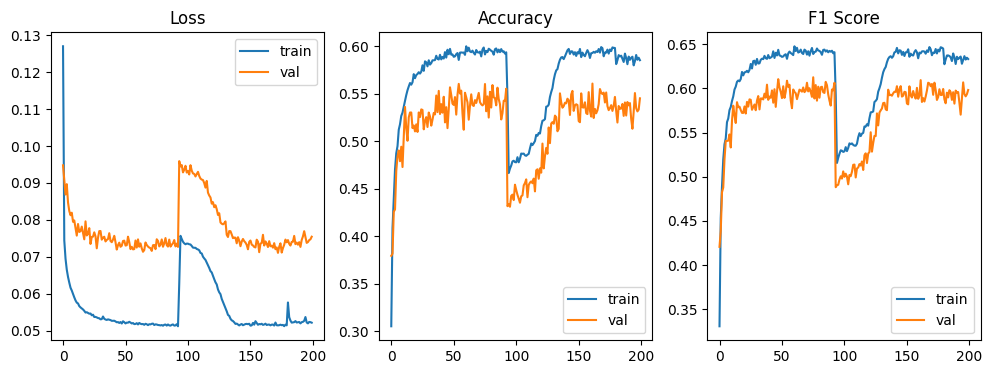

In [76]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history['train']['loss'], label='train')
plt.plot(history['val']['loss'], label='val')
plt.title('Loss')
plt.legend()

#plot the accuracy
plt.subplot(1, 3, 2)
plt.plot(history['train']['acc'], label='train')
plt.plot(history['val']['acc'], label='val')
plt.title('Accuracy')
plt.legend()

#plot the f1 score
plt.subplot(1, 3, 3)
plt.plot(history['train']['f1'], label='train')
plt.plot(history['val']['f1'], label='val')
plt.title('F1 Score')
plt.legend()

plt.show()


In [77]:
#save model
torch.save(model.state_dict(), "imporved_gru_ner_model.pth")

In [79]:
# Evaluate the first model (GRUModel) on the test set
model = GRUModel(len(vocab), NUM_CLASSES+1).to(DEVICE)
model.load_state_dict(torch.load("gru_ner_model.pth"))
model.eval()

test_loss = 0.0
test_acc = 0.0
test_f1 = 0.0

with torch.no_grad():
    for tokens, ner_tags in test_dataloader:
        tokens, ner_tags = tokens.to(DEVICE), ner_tags.to(DEVICE)
        output = model(tokens)

        loss = criterion(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        acc_score = acc(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        f1_score = f1(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))

        test_loss += loss.item()
        test_acc += acc_score.item()
        test_f1 += f1_score.item()

test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)
test_f1 = test_f1 / len(test_dataloader)

print(f"Test Loss (GRUModel): {test_loss:.4f}, Test Acc (GRUModel): {test_acc:.4f}, Test F1 (GRUModel): {test_f1:.4f}")

# Evaluate the second model (ImprovedGRUModel) on the test set
model = ImprovedGRUModel(len(vocab), NUM_CLASSES+1, embedding_matrix).to(DEVICE)
model.load_state_dict(torch.load("improved_gru_ner_model.pth"))
model.eval()

test_loss = 0.0
test_acc = 0.0
test_f1 = 0.0

with torch.no_grad():
    for tokens, ner_tags in test_dataloader:
        tokens, ner_tags = tokens.to(DEVICE), ner_tags.to(DEVICE)
        output = model(tokens)

        loss = criterion(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        acc_score = acc(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))
        f1_score = f1(output.view(-1, NUM_CLASSES+1), ner_tags.view(-1))

        test_loss += loss.item()
        test_acc += acc_score.item()
        test_f1 += f1_score.item()

test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)
test_f1 = test_f1 / len(test_dataloader)

print(f"Test Loss (ImprovedGRUModel): {test_loss:.4f}, Test Acc (ImprovedGRUModel): {test_acc:.4f}, Test F1 (ImprovedGRUModel): {test_f1:.4f}")

Test Loss (GRUModel): 0.2744, Test Acc (GRUModel): 0.4834, Test F1 (GRUModel): 0.4985
Test Loss (ImprovedGRUModel): 0.0743, Test Acc (ImprovedGRUModel): 0.5541, Test F1 (ImprovedGRUModel): 0.6014
